In [2]:
# !pip install refinitiv-data
# # version 1.0.0
# !pip install sklearn
# # version 0.0.post1
# !pip install hmmlearn
# # version 0.2.8
# !pip install plotly
# # version 5.11.0

In [3]:
# import refinitiv.data as rd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
import plotly.graph_objects as go
from plotly.graph_objs.scatter.marker import Line
from plotly.subplots import make_subplots
import plotly.express as px
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import math
import warnings
warnings.filterwarnings('ignore')

## Data Ingestion

In [4]:
# define symbol to collect data
symbol, interval, delay_minutes, start_year, start_month, start_day, end_year, end_month, end_day = 'BTCUSDT', '4h', 1, 2020, 1, 1, 2024, 6, 1

import binance_data_collection as binance_data_collection
binance_data = binance_data_collection.binance_data_collection(symbol, interval, delay_minutes, start_year, start_month, start_day, end_year, end_month, end_day) # symbol, interval, delay_minutes, start_year, start_month, start_day, end_year, end_month, end_day(end not included)

Data has been saved to BTCUSDT_2020_1_1_to_2024_6_1_with_4h.csv


In [5]:
df  = pd.read_csv(binance_data)
df = df[['real_time', 'close']]
df.columns = ['date', 'btc_close']
df = df.set_index('date')
df

,btc_close
date,
2020-01-01 00:00:00,7221.65
2020-01-01 04:00:00,7205.26
2020-01-01 08:00:00,7192.65
2020-01-01 12:00:00,7229.49
2020-01-01 16:00:00,7226.35
...,...
2024-05-31 04:00:00,68226.10
2024-05-31 08:00:00,68387.80
2024-05-31 12:00:00,67252.70


In [6]:
fig = px.line(df['btc_close'])
fig.update_layout(autosize=False, width=1000, height=600)

## Data Engineering

In [7]:
def prepare_data_for_model_input(prices, ma):
    '''
        Input:
        prices (df) - Dataframe of close prices
        ma (int) - legth of the moveing average
        
        Output:
        prices(df) - An enhanced prices dataframe, with moving averages and log return columns
        prices_array(nd.array) - an array of log returns
    '''
    
    # intrument = prices.columns.name
    prices[f'ma'] = prices.rolling(ma).mean()
    prices[f'log_return'] = np.log(prices[f'ma']/prices[f'ma'].shift(1)).dropna()
 
    prices.dropna(inplace = True)
    prices_array = np.array([[q] for q in prices[f'log_return'].values])
    
    return prices, prices_array

In [8]:
prices, prices_array = prepare_data_for_model_input(df, 6)
prices

,btc_close,ma,log_return
date,,,
2020-01-02 00:00:00,7127.29,7196.435000,-0.002183
2020-01-02 04:00:00,7107.56,7180.151667,-0.002265
2020-01-02 08:00:00,7136.24,7170.750000,-0.001310
2020-01-02 12:00:00,7126.25,7153.543333,-0.002402
2020-01-02 16:00:00,6979.44,7112.391667,-0.005769
...,...,...,...
2024-05-31 04:00:00,68226.10,68388.283333,0.001459
2024-05-31 08:00:00,68387.80,68476.966667,0.001296
2024-05-31 12:00:00,67252.70,68258.016667,-0.003203


## Regime Detection

In [9]:
class RegimeDetection:

    def get_regimes_kmeans(self, input_data, params):
        kmeans = self.initialise_model(KMeans(), params).fit(input_data)
        return kmeans
        
    def get_regimes_clustering(self, input_data, params):
        clustering = self.initialise_model(AgglomerativeClustering(), params)
        clustering.fit(input_data)
        return clustering
    
    def get_regimes_gmm(self, input_data, params):
        gmm = self.initialise_model(GaussianMixture(), params).fit(input_data)
        return gmm
    
    def get_regimes_hmm(self, input_data, params):
        hmm_model = self.initialise_model(GaussianHMM(), params).fit(input_data)
        return hmm_model
        
    def initialise_model(self, model, params):
        for parameter, value in params.items():
            setattr(model, parameter, value)
        return model

In [10]:
def plot_hidden_states(hidden_states, prices_df):
    
    '''
    Input:
    hidden_states(numpy.ndarray) - array of predicted hidden states
    prices_df(df) - dataframe of close prices
    
    Output:
    Graph showing hidden states and prices
    
    '''
    
    colors = ['blue', 'green']
    n_components = len(np.unique(hidden_states))
    fig = go.Figure()
 
    for i in range(n_components):
        mask = hidden_states == i
        print('Number of observations for State ', i,":", len(prices_df.index[mask]))
        
        fig.add_trace(go.Scatter(x=prices_df.index[mask], y=prices_df['btc_close'][mask],
                    mode='markers',  name='Hidden State ' + str(i), marker=dict(size=4,color=colors[i])))
        
    fig.update_layout(height=400, width=900, legend=dict(
            yanchor="top", y=0.99, xanchor="left",x=0.01), margin=dict(l=20, r=20, t=20, b=20)).show()

In [11]:
def plot_hidden_states2(hidden_states, prices_df):
    '''
    Plot hidden states as colored regions over time, separated by year.

    Parameters:
    - hidden_states (numpy.ndarray): Array of predicted hidden states.
    - prices_df (pd.DataFrame): DataFrame of close prices with a datetime index.

    Output:
    - A graph showing different hidden states as colored regions over time, grouped by year.
    '''    
    if not pd.api.types.is_datetime64_any_dtype(prices_df.index):
        prices_df.index = pd.to_datetime(prices_df.index)

    df = prices_df.copy()
    df['hidden_state'] = hidden_states
    df['year'] = df.index.year
    
    colors = ['blue', 'green']
    
    unique_years = df['year'].unique()

    for year in unique_years:
        plt.figure(figsize=(14, 2))
        year_data = df[df['year'] == year]
        
        for state in range(len(np.unique(hidden_states))):
            mask = year_data['hidden_state'] == state
            plt.fill_between(year_data.index, 0, 1, where=mask, color=colors[state], alpha=0.5, label='Hidden State ' + str(state), step='pre')

        plt.title(f'Market conditions - {year}')
        plt.xlabel('Date')
        plt.yticks([]) 
        plt.legend(loc='upper left')
        plt.tight_layout()
        plt.show()

In [12]:
regime_detection = RegimeDetection()

### K-means

Number of observations for State  0 : 3480
Number of observations for State  1 : 6192


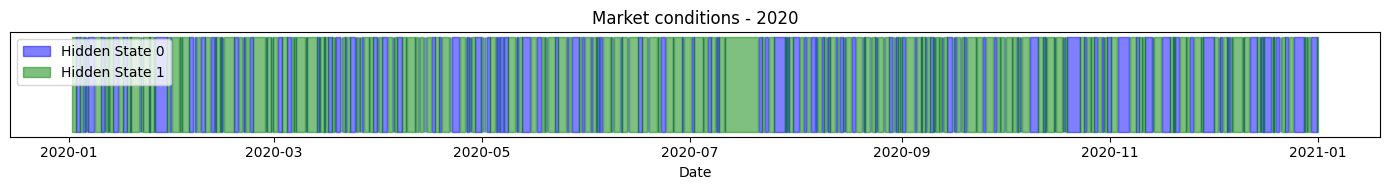

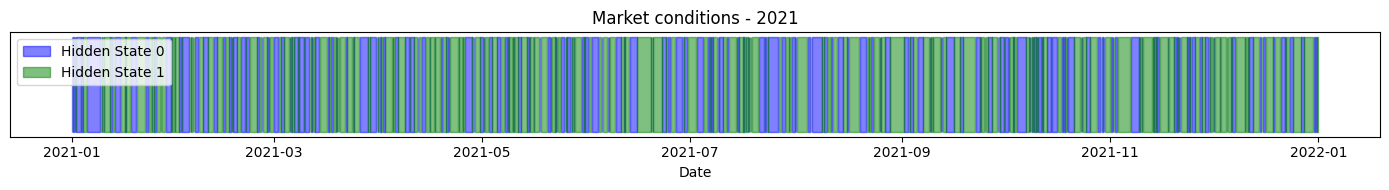

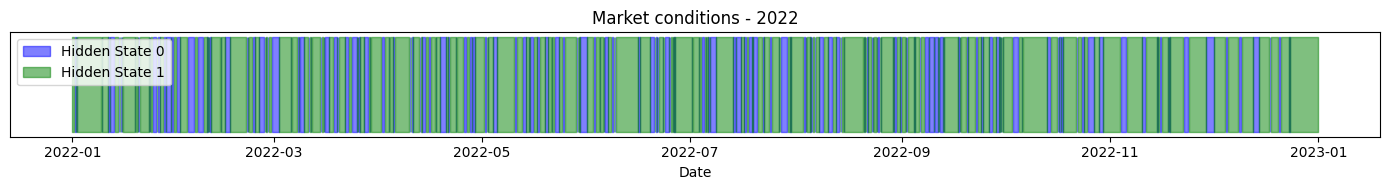

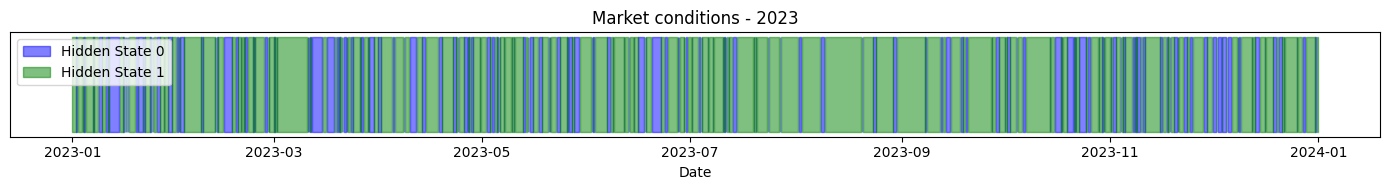

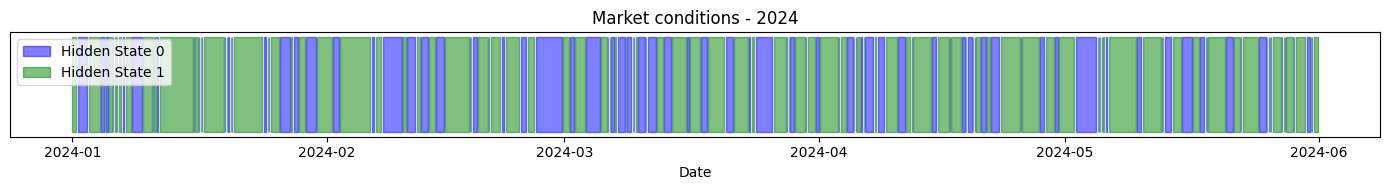

In [13]:
params = {'n_clusters': 2, 'random_state': 100}
kmeans_model = regime_detection.get_regimes_kmeans(prices_array, params)
kmeans_states = kmeans_model.labels_ 
plot_hidden_states(np.array(kmeans_states), prices[['btc_close']])
plot_hidden_states2(np.array(kmeans_states), prices[['btc_close']])

### AgglomerativeClustering

Number of observations for State  0 : 292
Number of observations for State  1 : 9380


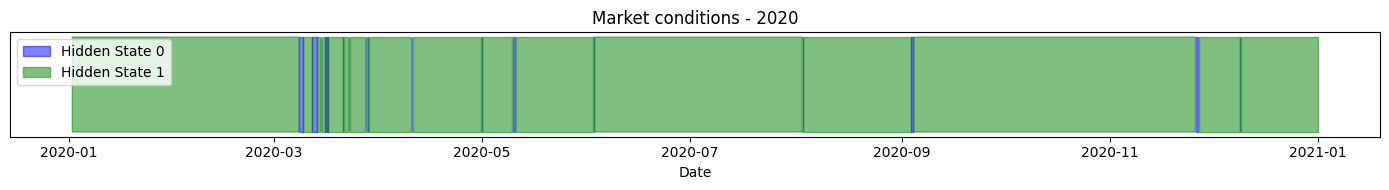

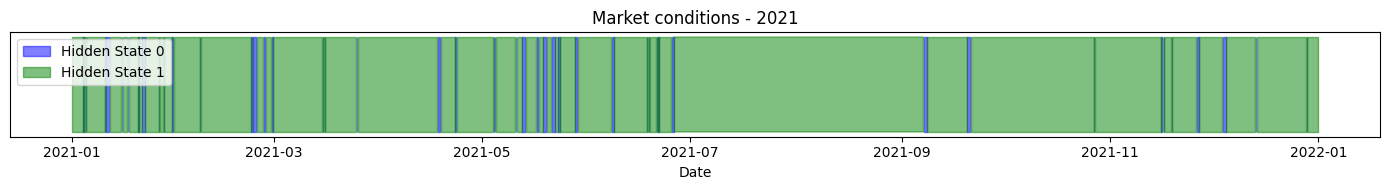

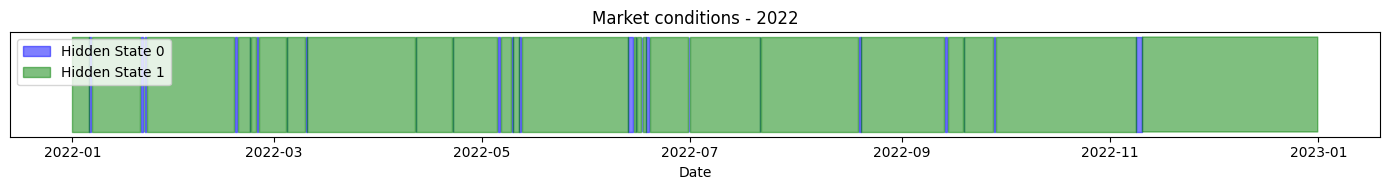

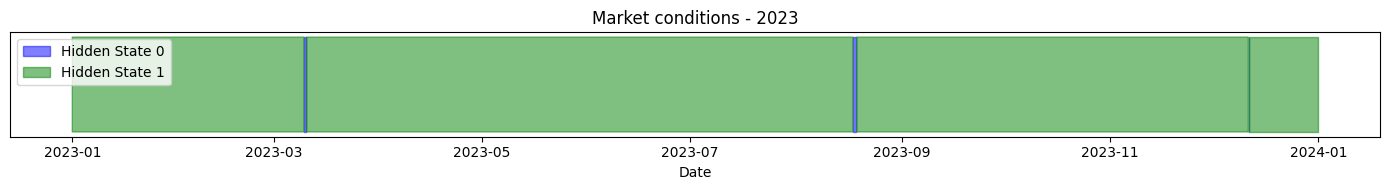

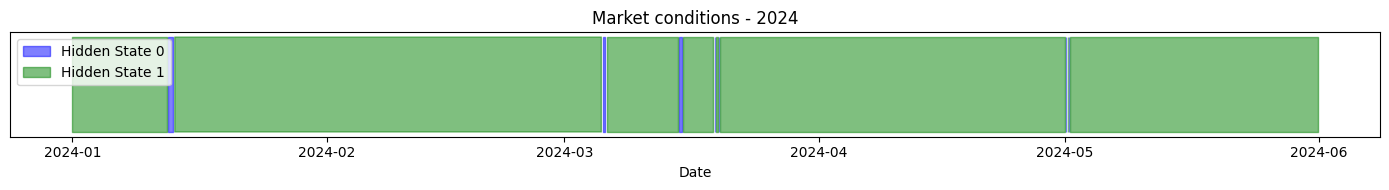

In [14]:
params = {'n_clusters': 2, 'linkage': 'complete', 'metric': 'manhattan', 'random_state': 100}
clustering = regime_detection.get_regimes_clustering(prices_array, params)
clustering_states = clustering.fit_predict(prices_array)
plot_hidden_states(np.array(clustering_states), prices[['btc_close']])
plot_hidden_states2(np.array(clustering_states), prices[['btc_close']])

### GaussianMixture

Number of observations for State  0 : 7514
Number of observations for State  1 : 2158


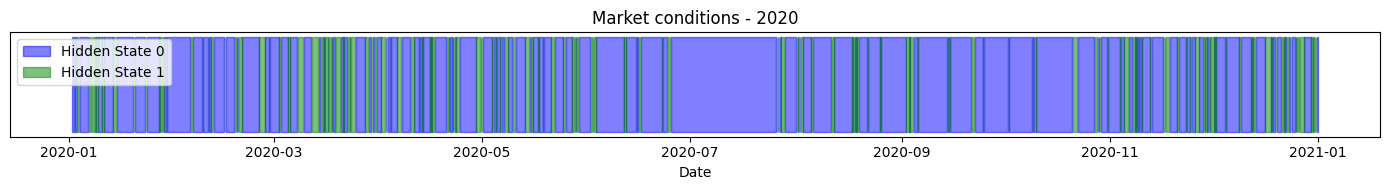

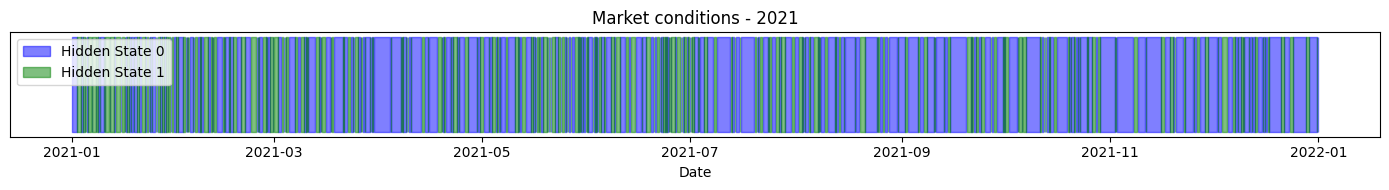

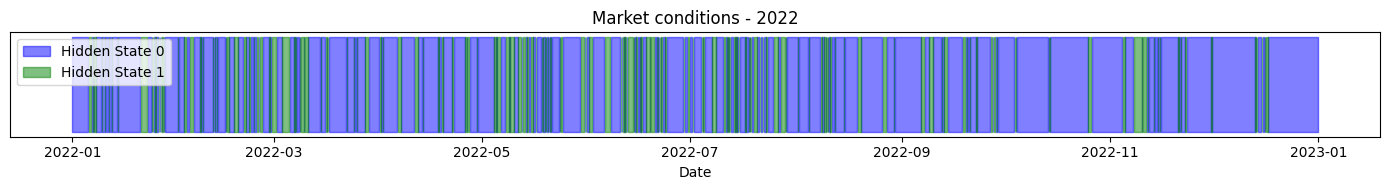

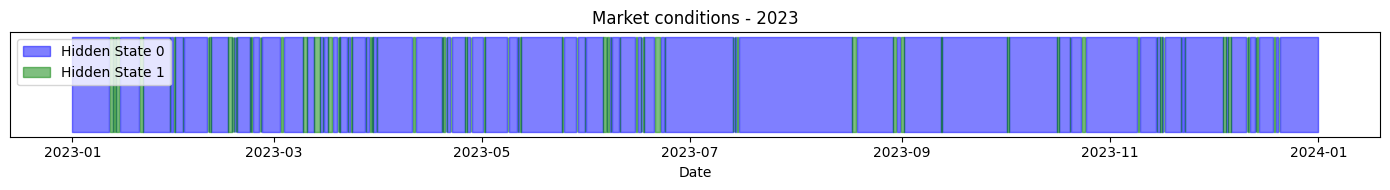

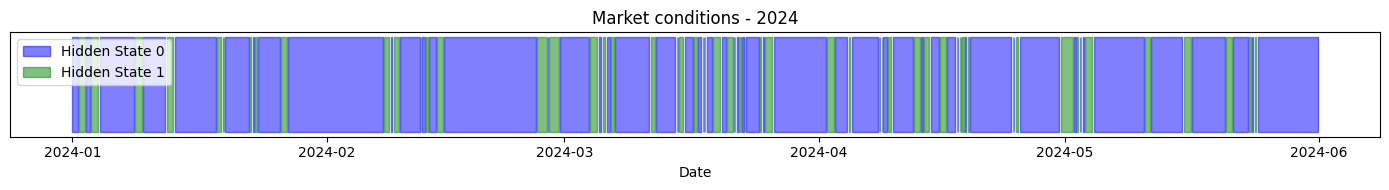

In [15]:
params = {'n_components':2, 'covariance_type': 'full', 'max_iter': 100000, 'n_init': 30,'init_params': 'kmeans', 'random_state':100}
gmm_model = regime_detection.get_regimes_gmm(prices_array, params)
gmm_states = gmm_model.predict(prices_array)
plot_hidden_states(np.array(gmm_states), prices[['btc_close']])
plot_hidden_states2(np.array(gmm_states), prices[['btc_close']])

### GaussianHMM

Number of observations for State  0 : 2038
Number of observations for State  1 : 7634


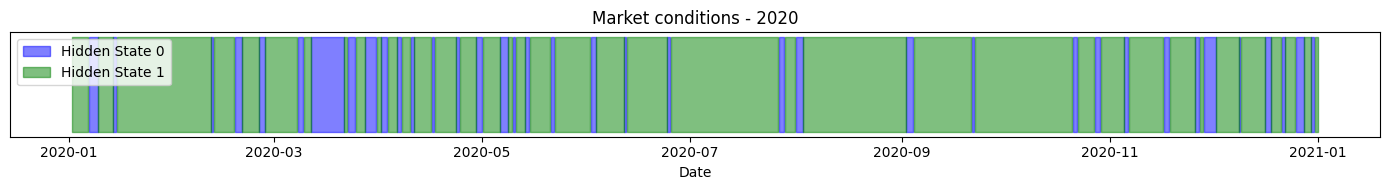

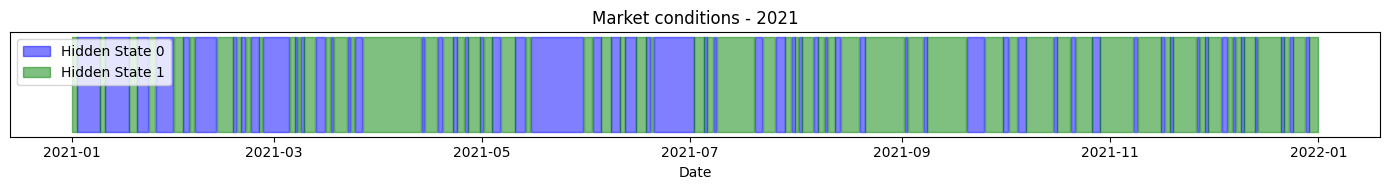

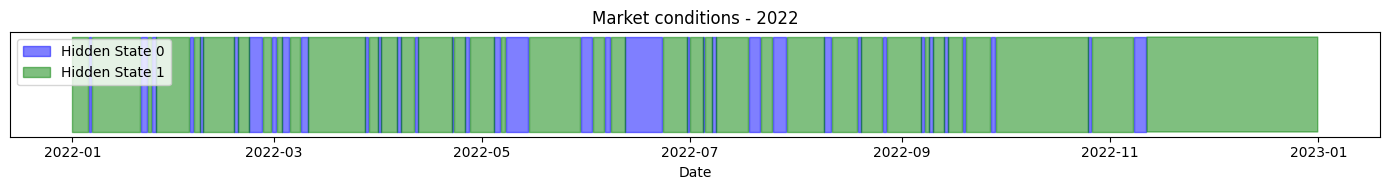

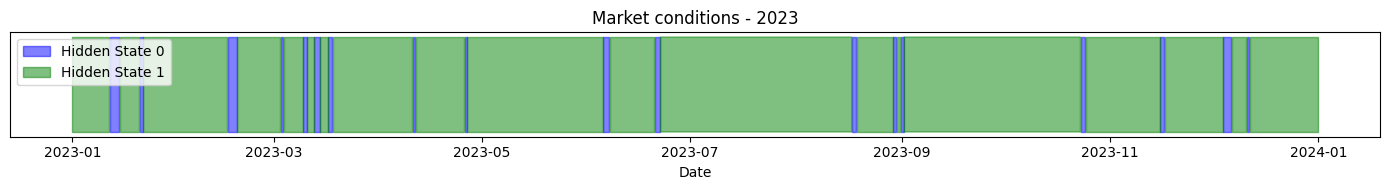

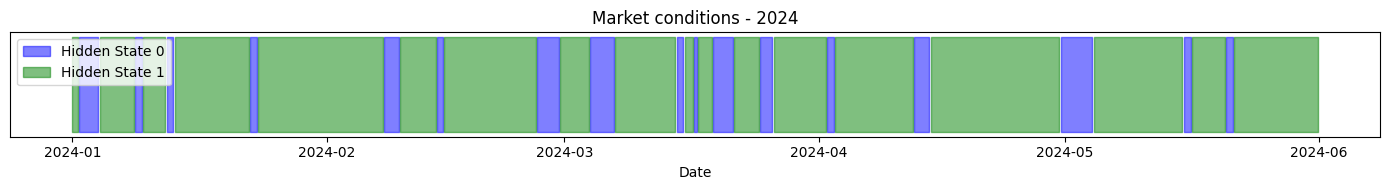

In [16]:
params = {'n_components':2, 'covariance_type':"full", 'random_state':100}
hmm_model = regime_detection.get_regimes_hmm(prices_array, params)
hmm_states = hmm_model.predict(prices_array)
plot_hidden_states(np.array(hmm_states), prices[['btc_close']])
plot_hidden_states2(np.array(hmm_states), prices[['btc_close']])

## Feed-forward training and out of sample testing

In [17]:
import numpy as np
import math

def feed_forward_training(model_func, params, prices, split_index, retrain_step, use_predict=True):
    '''
    Train a model and predict clusters incrementally with retraining. This function
    is designed to work with any model that has an optional fit and predict method.

    Parameters:
    - model_func (function): Function to initialize and fit the model.
    - params (dict): Dictionary of parameters for the model.
    - prices (DataFrame or numpy.ndarray): Data containing price information.
    - split_index (int): Index to split initial training dataset and out-of-sample testing set.
    - retrain_step (int): Number of observations after which we retrain the model.
    - use_predict (bool): If True, use model's predict method, otherwise refit model on each step.
    
    Returns:
    - numpy.ndarray: Array of predicted clusters.
    '''
    init_train_data = prices[:split_index]
    test_data = prices[split_index:]
    rd_model = model_func(init_train_data, params)

    states_pred = []
    for i in range(len(test_data)):
        if use_predict:
            preds = rd_model.predict(prices[:split_index + i + 1])
            states_pred.append(preds[-1])
        else:
            rd_model = model_func(prices[:split_index + i + 1], params)
            labels = rd_model.labels_
            states_pred.append(labels[-1])

        if (i + 1) % retrain_step == 0 and use_predict:
            rd_model = model_func(prices[:split_index + i + 1], params)
            
    return np.array(states_pred)

Number of observations for State  0 : 495
Number of observations for State  1 : 417


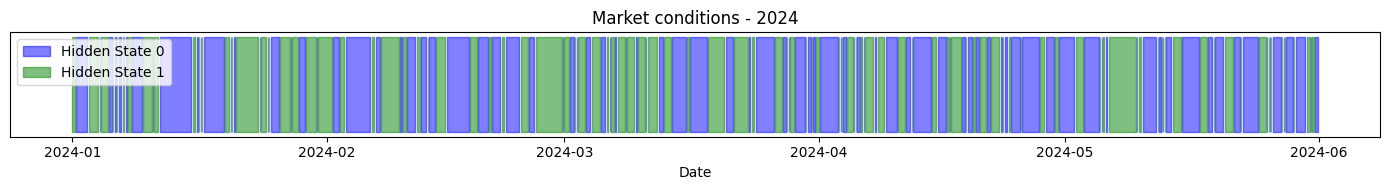

In [18]:
model_kmeans =  regime_detection.get_regimes_kmeans
params = {'n_clusters': 2, 'random_state': 100, 'n_init': 30}
split_index = np.where(prices.index >= '2024-01-01')[0][0]
states_pred_kmeans = feed_forward_training(model_kmeans, params, prices_array, split_index, 20)
plot_hidden_states(states_pred_kmeans, prices[['btc_close']][split_index:])
plot_hidden_states2(states_pred_kmeans, prices[['btc_close']][split_index:])

Number of observations for State  0 : 540
Number of observations for State  1 : 372


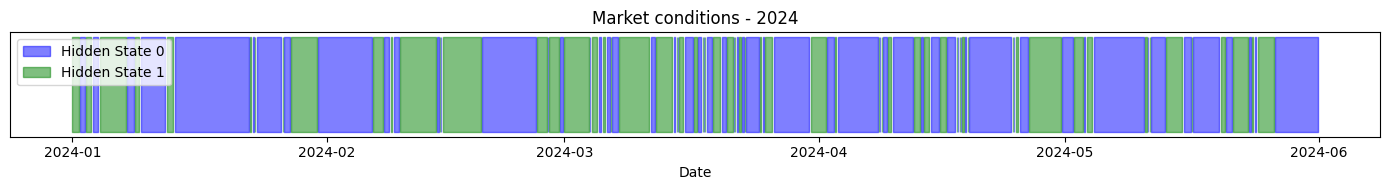

In [19]:
model_gmm =  regime_detection.get_regimes_gmm
params = {'n_components':2, 'covariance_type':"full", 'random_state':100, 'max_iter': 100000, 'n_init': 30,'init_params': 'kmeans', 'random_state':100}
states_pred_gmm = feed_forward_training(model_gmm, params, prices_array, split_index, 20)
plot_hidden_states(np.array(states_pred_gmm), prices[['btc_close']][split_index:])
plot_hidden_states2(np.array(states_pred_gmm), prices[['btc_close']][split_index:])

Number of observations for State  0 : 169
Number of observations for State  1 : 743


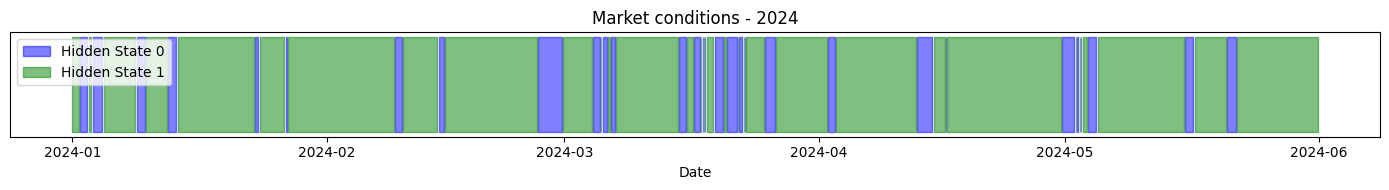

In [20]:
model_hmm =  regime_detection.get_regimes_hmm
params = {'n_components':2, 'covariance_type': 'full', 'random_state':100}
states_pred_hmm = feed_forward_training(model_hmm, params, prices_array, split_index, 20)
plot_hidden_states(np.array(states_pred_hmm), prices[['btc_close']][split_index:])
plot_hidden_states2(np.array(states_pred_hmm), prices[['btc_close']][split_index:])

## Implementing an Investment Strategy

In [37]:
prices_with_states = pd.DataFrame(prices[split_index:]['btc_close'])
prices_with_states['State_kmeans'] = states_pred_kmeans
prices_with_states['State_gmm'] = states_pred_gmm
prices_with_states['State_hmm'] = states_pred_hmm
prices_with_states.head()

,btc_close,State_kmeans,State_gmm,State_hmm
date,,,,
2024-01-01 00:00:00,42369.8,1,1,1
2024-01-01 04:00:00,42527.0,1,1,1
2024-01-01 08:00:00,42727.6,1,1,1
2024-01-01 12:00:00,42818.0,0,1,1
2024-01-01 16:00:00,43556.2,0,1,1


In [38]:
# prices_with_states['P&L_daily'] = np.log(prices_with_states['btc_close'] / prices_with_states['btc_close'].shift(1)).dropna()
prices_with_states['P&L_daily'] = prices_with_states['btc_close'].pct_change()
prices_with_states.head()

,btc_close,State_kmeans,State_gmm,State_hmm,P&L_daily
date,,,,,
2024-01-01 00:00:00,42369.8,1,1,1,NaN
2024-01-01 04:00:00,42527.0,1,1,1,0.003710
2024-01-01 08:00:00,42727.6,1,1,1,0.004717
2024-01-01 12:00:00,42818.0,0,1,1,0.002116
2024-01-01 16:00:00,43556.2,0,1,1,0.017240


In [39]:
prices_with_states['State_kmeans'] = prices_with_states['State_kmeans'].shift(1)
prices_with_states['State_hmm'] = prices_with_states['State_hmm'].shift(1)
prices_with_states['State_gmm'] = prices_with_states['State_gmm'].shift(1)
prices_with_states.dropna(inplace = True)

In [40]:
prices_with_states['Position_kmeans'] = np.where(prices_with_states['State_kmeans'] == 1,-1,1)
prices_with_states['Position_hmm'] = np.where(prices_with_states['State_hmm'] == 1,-1,1)
prices_with_states['Position_gmm'] = np.where(prices_with_states['State_gmm'] == 1,1,-1)
prices_with_states.head()

,btc_close,State_kmeans,State_gmm,State_hmm,P&L_daily,Position_kmeans,Position_hmm,Position_gmm
date,,,,,,,,
2024-01-01 04:00:00,42527.0,1.0,1.0,1.0,0.003710,-1,-1,1
2024-01-01 08:00:00,42727.6,1.0,1.0,1.0,0.004717,-1,-1,1
2024-01-01 12:00:00,42818.0,1.0,1.0,1.0,0.002116,-1,-1,1
2024-01-01 16:00:00,43556.2,0.0,1.0,1.0,0.017240,1,-1,1
2024-01-01 20:00:00,44230.2,0.0,1.0,1.0,0.015474,1,-1,1


In [41]:
def calculate_position_all(row):
    positions = [row['Position_kmeans'], row['Position_hmm'], row['Position_gmm']]
    most_common = max(set(positions), key=positions.count)
    count_most_common = positions.count(most_common)
    if count_most_common == 3:
        return most_common * 5
    else:
        return 0
    
# def calculate_position_all(row):
#     positions = [row['Position_kmeans'], row['Position_hmm'], row['Position_gmm']]
#     position_set = set(positions)
    
#     if len(position_set) == 1:
#         return positions[0]
#     elif len(position_set) == 2:
#         for pos in position_set:
#             if positions.count(pos) == 1:
#                 return pos
#     else:
#         return -1
    
prices_with_states['Position_all'] = prices_with_states.apply(calculate_position_all, axis=1)

In [42]:
prices_with_states['Daily_Outcome_kmeans'] = prices_with_states['Position_kmeans'] * prices_with_states['P&L_daily']
prices_with_states['Daily_Outcome_gmm'] = prices_with_states['Position_gmm'] * prices_with_states['P&L_daily']
prices_with_states['Daily_Outcome_hmm'] = prices_with_states['Position_hmm'] * prices_with_states['P&L_daily']
prices_with_states['Daily_Outcome_all'] = prices_with_states['Position_all'] * prices_with_states['P&L_daily']
prices_with_states['Cumulative_Outcome_BaH'] = prices_with_states['P&L_daily'].cumsum()
prices_with_states['Cumulative_Outcome_kmeans'] = prices_with_states['Daily_Outcome_kmeans'].cumsum()
prices_with_states['Cumulative_Outcome_hmm'] = prices_with_states['Daily_Outcome_hmm'].cumsum()
prices_with_states['Cumulative_Outcome_gmm'] = prices_with_states['Daily_Outcome_gmm'].cumsum()
prices_with_states['Cumulative_Outcome_all'] = prices_with_states['Daily_Outcome_all'].cumsum()
prices_with_states.head()

,btc_close,State_kmeans,State_gmm,State_hmm,P&L_daily,Position_kmeans,Position_hmm,Position_gmm,Position_all,Daily_Outcome_kmeans,Daily_Outcome_gmm,Daily_Outcome_hmm,Daily_Outcome_all,Cumulative_Outcome_BaH,Cumulative_Outcome_kmeans,Cumulative_Outcome_hmm,Cumulative_Outcome_gmm,Cumulative_Outcome_all
date,,,,,,,,,,,,,,,,,,
2024-01-01 04:00:00,42527.0,1.0,1.0,1.0,0.003710,-1,-1,1,0.0,-0.003710,0.003710,-0.003710,0.0,0.003710,-0.003710,-0.003710,0.003710,0.0
2024-01-01 08:00:00,42727.6,1.0,1.0,1.0,0.004717,-1,-1,1,0.0,-0.004717,0.004717,-0.004717,0.0,0.008427,-0.008427,-0.008427,0.008427,0.0
2024-01-01 12:00:00,42818.0,1.0,1.0,1.0,0.002116,-1,-1,1,0.0,-0.002116,0.002116,-0.002116,0.0,0.010543,-0.010543,-0.010543,0.010543,0.0
2024-01-01 16:00:00,43556.2,0.0,1.0,1.0,0.017240,1,-1,1,0.0,0.017240,0.017240,-0.017240,0.0,0.027783,0.006697,-0.027783,0.027783,0.0
2024-01-01 20:00:00,44230.2,0.0,1.0,1.0,0.015474,1,-1,1,0.0,0.015474,0.015474,-0.015474,0.0,0.043258,0.022172,-0.043258,0.043258,0.0


In [43]:
fig = go.Figure()
 
fig.add_trace(go.Line(x=prices_with_states.index, y=prices_with_states["Cumulative_Outcome_BaH"], 
                      name = 'Cumulative_Outcome_BaH', line_color = 'navy'))

fig.add_trace(go.Line(x= prices_with_states.index, y=prices_with_states['Cumulative_Outcome_kmeans'], 
                      name = 'Cumulative_Outcome_kmeans', line_color = 'teal'))
 
fig.add_trace(go.Line(x= prices_with_states.index, y=prices_with_states['Cumulative_Outcome_hmm'], 
                      name = 'Cumulative_Outcome_hmm', line_color = 'olive'))

fig.add_trace(go.Line(x= prices_with_states.index, y=prices_with_states['Cumulative_Outcome_gmm'], 
                      name = 'Cumulative_Outcome_gmm', line_color = 'slategray'))

fig.add_trace(go.Line(x= prices_with_states.index, y=prices_with_states['Cumulative_Outcome_all'], 
                      name = 'Cumulative_Outcome_all', line_color='maroon'))

fig.update_layout(height=400, width=900, legend=dict(
    yanchor="top", y=0.99, xanchor="left",x=0.01), 
    margin=dict(l=20, r=20, t=20, b=20))
 
fig.show()

d:\app\anaconda\envs\gputorch\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [36]:
import quantstats as qs
prices_with_states.index = pd.to_datetime(prices_with_states.index)
qs.reports.html(prices_with_states['Daily_Outcome_kmeans'], prices_with_states['P&L_daily'], output='kmeans_report3.html')
qs.reports.html(prices_with_states['Daily_Outcome_hmm'], prices_with_states['P&L_daily'], output='hmm_report3.html')
qs.reports.html(prices_with_states['Daily_Outcome_gmm'], prices_with_states['P&L_daily'], output='gmm_report3.html')
qs.reports.html(prices_with_states['Daily_Outcome_all'], prices_with_states['P&L_daily'], output='all_report3.html')
